<a href="https://colab.research.google.com/github/ApurvaMayank-iitb/24D0894_IE643_NIFTI/blob/main/AnoGAN_24D0894.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import numpy as np

# Upload the .npy file(s)
uploaded = files.upload()

# Load the uploaded file(s) into numpy arrays
# Assume the uploaded file has a specific name, e.g., "preprocessed_sample.npy"
for filename in uploaded.keys():
    print(f"File {filename} uploaded successfully!")
    data = np.load(filename)
    print(f"Loaded data shape: {data.shape}")


Saving BraTS20_Training_001_best_slice.npy to BraTS20_Training_001_best_slice.npy
File BraTS20_Training_001_best_slice.npy uploaded successfully!
Loaded data shape: (256, 256)


In [2]:
import torch

# Convert the data to a PyTorch tensor, add batch and channel dimensions
data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 256, 256]

# Move tensor to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_tensor = data_tensor.to(device)

print(f"Data tensor shape: {data_tensor.shape}")
print(f"Data tensor device: {data_tensor.device}")


Data tensor shape: torch.Size([1, 1, 256, 256])
Data tensor device: cpu


In [3]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_dim=100, output_channels=1):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.ConvTranspose2d(input_dim, 64, kernel_size=4, stride=1, padding=0),  # Upsample from 1x1 to 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Upsample to 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1),  # Output to 256x256
            nn.Tanh()  # Output values between -1 and 1 for normalized image
        )

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)  # Reshape to start with a 1x1 input
        return self.net(x)


In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=1):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),  # Downsample to 128x128
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Downsample to 64x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 1, kernel_size=4, stride=1, padding=0),  # Downsample further to a single output
            nn.Sigmoid()  # Probability of being real or fake
        )

    def forward(self, x):
        return self.net(x).view(-1, 1).squeeze(1)  # Flatten the output


In [5]:
# Initialize the models
latent_dim = 100  # Dimension of the random noise vector
G = Generator(input_dim=latent_dim, output_channels=1).to(device)
D = Discriminator(input_channels=1).to(device)

# Print model summaries (optional)
print("Generator Model:\n", G)
print("Discriminator Model:\n", D)


Generator Model:
 Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)
Discriminator Model:
 Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1)

In [6]:
# Confirm data and model devices
print(f"Data tensor device: {data_tensor.device}")
print(f"Generator device: {next(G.parameters()).device}")
print(f"Discriminator device: {next(D.parameters()).device}")


Data tensor device: cpu
Generator device: cpu
Discriminator device: cpu


In [7]:
# Update device setting for GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move data and models to the correct device
data_tensor = data_tensor.to(device)
G = G.to(device)
D = D.to(device)

# Verify again
print(f"Data tensor device: {data_tensor.device}")
print(f"Generator device: {next(G.parameters()).device}")
print(f"Discriminator device: {next(D.parameters()).device}")


Data tensor device: cpu
Generator device: cpu
Discriminator device: cpu


In [8]:
import torch.optim as optim

# Define optimizers for both generator and discriminator
lr = 0.0002
beta1 = 0.5  # Adam optimizer beta1 hyperparameter
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()  # Binary cross-entropy loss

# Training parameters
epochs = 200  # Number of epochs for training
latent_dim = 100  # Dimension of the latent space

for epoch in range(epochs):
    ############################
    # (1) Train Discriminator
    ###########################
    optimizer_D.zero_grad()

    # Real data
    real_labels = torch.ones((1,), device=device)  # Real label = 1
    output_real = D(data_tensor)  # Discriminator's prediction on real image
    loss_real = criterion(output_real, real_labels)

    # Fake data
    noise = torch.randn((1, latent_dim), device=device)  # Generate random noise vector
    fake_img = G(noise)  # Generate a fake image from noise
    fake_labels = torch.zeros((1,), device=device)  # Fake label = 0
    output_fake = D(fake_img.detach())  # Detach to avoid gradients in G
    loss_fake = criterion(output_fake, fake_labels)

    # Total discriminator loss
    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer_D.step()

    ############################
    # (2) Train Generator
    ###########################
    optimizer_G.zero_grad()

    # Generator attempts to fool discriminator (real label to trick D)
    output_fake = D(fake_img)
    loss_G = criterion(output_fake, real_labels)  # Use real label for fake image
    loss_G.backward()
    optimizer_G.step()

    # Print loss values every 50 epochs for tracking
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}")


ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([3721])) is deprecated. Please ensure they have the same size.

In [9]:
for epoch in range(epochs):
    ############################
    # (1) Train Discriminator
    ###########################
    optimizer_D.zero_grad()

    # Real data
    output_real = D(data_tensor).view(-1)  # Flatten the output to 1D
    real_labels = torch.ones_like(output_real, device=device)  # Match shape with output_real
    loss_real = criterion(output_real, real_labels)

    # Fake data
    noise = torch.randn((1, latent_dim), device=device)  # Generate random noise vector
    fake_img = G(noise)  # Generate a fake image from noise
    output_fake = D(fake_img.detach()).view(-1)  # Flatten the output to 1D
    fake_labels = torch.zeros_like(output_fake, device=device)  # Match shape with output_fake
    loss_fake = criterion(output_fake, fake_labels)

    # Total discriminator loss
    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer_D.step()

    ############################
    # (2) Train Generator
    ###########################
    optimizer_G.zero_grad()

    # Generator attempts to fool discriminator
    output_fake = D(fake_img).view(-1)  # Flatten the output to 1D
    loss_G = criterion(output_fake, real_labels)  # Use real labels to "trick" discriminator
    loss_G.backward()
    optimizer_G.step()

    # Print loss values every 50 epochs for tracking
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}")


ValueError: Using a target size (torch.Size([3721])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.

In [10]:
for epoch in range(epochs):
    ############################
    # (1) Train Discriminator
    ###########################
    optimizer_D.zero_grad()

    # Real data
    output_real = D(data_tensor).view(-1)  # Flatten the output to 1D
    real_labels = torch.ones_like(output_real, device=device)  # Match shape with output_real
    loss_real = criterion(output_real, real_labels)

    # Fake data
    noise = torch.randn((1, latent_dim), device=device)  # Generate random noise vector
    fake_img = G(noise)  # Generate a fake image from noise
    output_fake = D(fake_img.detach()).view(-1)  # Flatten the output to 1D
    fake_labels = torch.zeros_like(output_fake, device=device)  # Match shape with output_fake
    loss_fake = criterion(output_fake, fake_labels)

    # Total discriminator loss
    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer_D.step()

    ############################
    # (2) Train Generator
    ###########################
    optimizer_G.zero_grad()

    # Generator attempts to fool discriminator
    output_fake = D(fake_img).view(-1)  # Flatten the output to 1D

    # Define real_labels to match the shape of output_fake for the generator's loss
    real_labels_for_G = torch.ones_like(output_fake, device=device)  # Match shape with output_fake
    loss_G = criterion(output_fake, real_labels_for_G)  # Use real labels to "trick" discriminator
    loss_G.backward()
    optimizer_G.step()

    # Print loss values every 50 epochs for tracking
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}")


Epoch [50/200], Loss_D: 0.7357, Loss_G: 1.4954
Epoch [100/200], Loss_D: 0.3967, Loss_G: 2.2631
Epoch [150/200], Loss_D: 0.2233, Loss_G: 2.9603
Epoch [200/200], Loss_D: 0.1286, Loss_G: 3.6241


In [11]:
import numpy as np

def anomaly_score(real_img, generator, latent_dim, threshold_factor=2):
    """
    Computes the anomaly score by calculating the reconstruction error
    between the real image and the generated image.
    """
    # Generate an image similar to the real image using the trained generator
    noise = torch.randn((1, latent_dim), device=device)  # Random noise in latent space
    with torch.no_grad():
        generated_img = generator(noise).squeeze().cpu().numpy()  # Remove batch dimension

    # Move real image to CPU for processing and remove batch and channel dimensions
    real_img_np = real_img.squeeze().cpu().numpy()

    # Calculate reconstruction error (absolute difference)
    reconstruction_error = np.abs(real_img_np - generated_img)

    # Determine a threshold based on mean and standard deviation of reconstruction error
    mean_error = np.mean(reconstruction_error)
    std_error = np.std(reconstruction_error)
    threshold = mean_error + threshold_factor * std_error  # Adjust threshold factor as needed

    # Create an anomaly mask where error exceeds the threshold
    anomaly_mask = reconstruction_error > threshold
    anomaly_ratio = np.sum(anomaly_mask) / anomaly_mask.size

    # Output results
    print("Anomaly Ratio:", anomaly_ratio)
    if anomaly_ratio > 0.05:  # Example threshold for declaring an anomaly
        print("Tumor Found!")
    else:
        print("No Tumor Found.")

    return reconstruction_error, anomaly_mask

# Test the anomaly detection
reconstruction_error, anomaly_mask = anomaly_score(data_tensor, G, latent_dim=100)


ValueError: operands could not be broadcast together with shapes (256,256) (16,16) 

In [12]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_dim=100, output_channels=1):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.ConvTranspose2d(input_dim, 512, kernel_size=4, stride=1, padding=0),  # 1x1 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=4, padding=0),  # 64x64 -> 256x256
            nn.Tanh()  # Output values between -1 and 1 for normalized image
        )

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)  # Reshape to start with a 1x1 input
        return self.net(x)


In [13]:
G = Generator(input_dim=100, output_channels=1).to(device)


In [14]:
for epoch in range(epochs):
    ############################
    # (1) Train Discriminator
    ###########################
    optimizer_D.zero_grad()

    # Real data
    output_real = D(data_tensor).view(-1)  # Flatten the output to 1D
    real_labels = torch.ones_like(output_real, device=device)  # Match shape with output_real
    loss_real = criterion(output_real, real_labels)

    # Fake data
    noise = torch.randn((1, latent_dim), device=device)  # Generate random noise vector
    fake_img = G(noise)  # Generate a fake image from noise
    output_fake = D(fake_img.detach()).view(-1)  # Flatten the output to 1D
    fake_labels = torch.zeros_like(output_fake, device=device)  # Match shape with output_fake
    loss_fake = criterion(output_fake, fake_labels)

    # Total discriminator loss
    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer_D.step()

    ############################
    # (2) Train Generator
    ###########################
    optimizer_G.zero_grad()

    # Generator attempts to fool discriminator
    output_fake = D(fake_img).view(-1)  # Flatten the output to 1D

    # Define real_labels to match the shape of output_fake for the generator's loss
    real_labels_for_G = torch.ones_like(output_fake, device=device)  # Match shape with output_fake
    loss_G = criterion(output_fake, real_labels_for_G)  # Use real labels to "trick" discriminator
    loss_G.backward()
    optimizer_G.step()

    # Print loss values every 50 epochs for tracking
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}")


Epoch [50/200], Loss_D: 1.0493, Loss_G: 0.9975
Epoch [100/200], Loss_D: 0.8308, Loss_G: 1.2138
Epoch [150/200], Loss_D: 0.6630, Loss_G: 1.4124
Epoch [200/200], Loss_D: 0.5015, Loss_G: 1.6406


In [15]:
import numpy as np

def anomaly_score(real_img, generator, latent_dim, threshold_factor=2):
    """
    Computes the anomaly score by calculating the reconstruction error
    between the real image and the generated image.
    """
    # Generate an image similar to the real image using the trained generator
    noise = torch.randn((1, latent_dim), device=device)  # Random noise in latent space
    with torch.no_grad():
        generated_img = generator(noise).squeeze().cpu().numpy()  # Remove batch dimension

    # Move real image to CPU for processing and remove batch and channel dimensions
    real_img_np = real_img.squeeze().cpu().numpy()

    # Calculate reconstruction error (absolute difference)
    reconstruction_error = np.abs(real_img_np - generated_img)

    # Determine a threshold based on mean and standard deviation of reconstruction error
    mean_error = np.mean(reconstruction_error)
    std_error = np.std(reconstruction_error)
    threshold = mean_error + threshold_factor * std_error  # Adjust threshold factor as needed

    # Create an anomaly mask where error exceeds the threshold
    anomaly_mask = reconstruction_error > threshold
    anomaly_ratio = np.sum(anomaly_mask) / anomaly_mask.size

    # Output results
    print("Anomaly Ratio:", anomaly_ratio)
    if anomaly_ratio > 0.05:  # Example threshold for declaring an anomaly
        print("Tumor Found!")
    else:
        print("No Tumor Found.")

    return reconstruction_error, anomaly_mask

# Test the anomaly detection
reconstruction_error, anomaly_mask = anomaly_score(data_tensor, G, latent_dim=100)


Anomaly Ratio: 0.0460357666015625
No Tumor Found.


In [16]:
from google.colab import files
import nibabel as nib
import numpy as np
import cv2
import torch

# Step 1: Upload multiple .nii files (one for each modality)
def upload_nii_files():
    """
    Use Google Colab to upload multiple .nii files (excluding segmentation files).
    """
    uploaded = files.upload()  # This will prompt the user to upload multiple .nii files
    modalities = {}  # Dictionary to store the modalities

    for filename in uploaded.keys():
        if 'seg' not in filename.lower():  # Exclude segmentation files
            print(f"File {filename} uploaded successfully!")
            modalities[filename] = filename  # Store the filenames of modalities

    return modalities

# Step 2: Load and preprocess the modalities, and average them into a single channel
def load_and_average_modalities(modalities, slice_axis=2, target_size=(256, 256)):
    """
    Load multiple .nii files (modalities), extract the best slice from each,
    preprocess, and average them into a single channel.
    """
    processed_slices = []

    # Process each modality
    for modality_name, file_path in modalities.items():
        # Load the .nii file
        img = nib.load(file_path)
        data = img.get_fdata()  # Convert to numpy array

        # Extract slices along the desired axis (default is the axial view, axis=2)
        slices = [data.take(i, axis=slice_axis) for i in range(data.shape[slice_axis])]

        # Find the slice with the maximum non-zero pixels
        non_zero_counts = [np.count_nonzero(slice_) for slice_ in slices]
        max_index = np.argmax(non_zero_counts)  # Index of the slice with the most non-zero pixels
        best_slice = slices[max_index]

        # Resize the slice to the target size (e.g., 256x256)
        best_slice_resized = cv2.resize(best_slice, target_size)

        # Normalize the slice to the range [0, 1]
        best_slice_normalized = best_slice_resized / np.max(best_slice_resized) if np.max(best_slice_resized) > 0 else best_slice_resized

        # Append the preprocessed slice to the list
        processed_slices.append(best_slice_normalized)

    # Average the slices from different modalities to get a single-channel image
    averaged_slice = np.mean(processed_slices, axis=0)  # Average across modalities

    return averaged_slice

# Step 3: Convert the preprocessed single-channel slice to a PyTorch tensor
def preprocess_for_model(averaged_slice, device):
    """
    Convert the averaged slice to a PyTorch tensor with batch and channel dimensions.
    """
    tensor = torch.tensor(averaged_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Shape: [1, 1, H, W]
    return tensor

# Step 4: Evaluate the model on the prepared tensor and calculate anomaly score
def evaluate_anomaly(validation_tensor, generator, latent_dim=100, threshold_factor=2):
    """
    Run the trained generator on the validation tensor and calculate anomaly score.
    """
    # Generate an image similar to the real image using the trained generator
    noise = torch.randn((1, latent_dim), device=device)  # Random noise in latent space
    with torch.no_grad():
        generated_img = generator(noise).squeeze().cpu().numpy()  # Remove batch dimension

    # Move validation image to CPU for processing and remove batch and channel dimensions
    real_img_np = validation_tensor.squeeze().cpu().numpy()

    # Calculate reconstruction error (absolute difference)
    reconstruction_error = np.abs(real_img_np - generated_img)

    # Determine a threshold based on mean and standard deviation of reconstruction error
    mean_error = np.mean(reconstruction_error)
    std_error = np.std(reconstruction_error)
    threshold = mean_error + threshold_factor * std_error  # Adjust threshold factor as needed

    # Create an anomaly mask where error exceeds the threshold
    anomaly_mask = reconstruction_error > threshold
    anomaly_ratio = np.sum(anomaly_mask) / anomaly_mask.size

    # Output results
    print("Anomaly Ratio:", anomaly_ratio)
    if anomaly_ratio > 0.05:  # Example threshold for declaring an anomaly
        print("Tumor Found!")
    else:
        print("No Tumor Found.")

    return reconstruction_error, anomaly_mask

# Main: Run the complete validation procedure
# Step 1: Upload multiple modalities
modalities = upload_nii_files()

# Step 2: Load, average, and preprocess the modalities
averaged_slice = load_and_average_modalities(modalities)
print("Averaged slice shape:", averaged_slice.shape)

# Step 3: Convert to PyTorch tensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
validation_tensor = preprocess_for_model(averaged_slice, device)

# Step 4: Evaluate anomaly detection
reconstruction_error, anomaly_mask = evaluate_anomaly(validation_tensor, G, latent_dim=100)


Saving BraTS20_Validation_001_t1ce.nii to BraTS20_Validation_001_t1ce.nii
Saving BraTS20_Validation_001_t2.nii to BraTS20_Validation_001_t2.nii
File BraTS20_Validation_001_t1ce.nii uploaded successfully!
File BraTS20_Validation_001_t2.nii uploaded successfully!
Averaged slice shape: (256, 256)
Anomaly Ratio: 0.043792724609375
No Tumor Found.


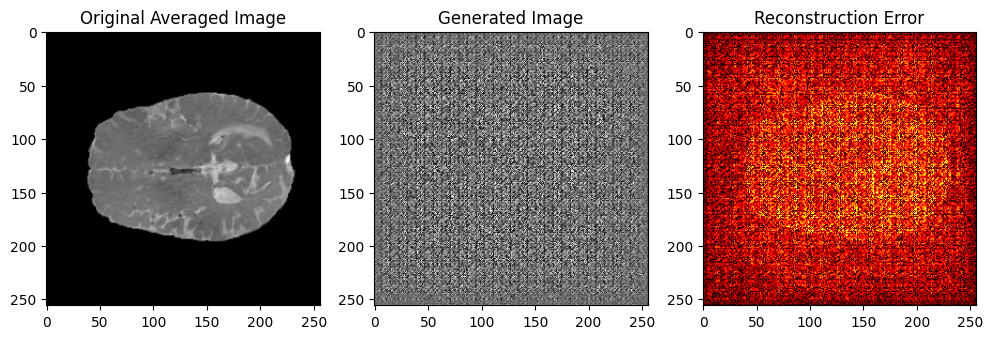

In [17]:
import matplotlib.pyplot as plt

# Plot the original, generated image, and reconstruction error
plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Averaged Image")
plt.imshow(validation_tensor.squeeze().cpu().numpy(), cmap='gray')

# Generated Image (Fake Image)
noise = torch.randn((1, latent_dim), device=device)
with torch.no_grad():
    generated_img = G(noise).squeeze().cpu().numpy()

plt.subplot(1, 3, 2)
plt.title("Generated Image")
plt.imshow(generated_img, cmap='gray')

# Reconstruction Error
plt.subplot(1, 3, 3)
plt.title("Reconstruction Error")
plt.imshow(reconstruction_error, cmap='hot')

plt.show()


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modified Generator
class Generator(nn.Module):
    def __init__(self, input_dim=25, output_channels=1):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.ConvTranspose2d(input_dim, 128, kernel_size=4, stride=1, padding=0),  # 1x1 -> 4x4
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, output_channels, kernel_size=8, stride=16, padding=0),  # Upscale directly to 256x256
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)  # Reshape to start with a 1x1 input
        return self.net(x)

# Modified Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_channels=1):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),  # Downsample to 128x128
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Downsample to 64x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 1, kernel_size=4, stride=1, padding=0),  # Further downsample to a single output
            nn.Sigmoid()  # Probability of real or fake
        )

    def forward(self, x):
        return self.net(x).view(-1, 1).squeeze(1)  # Flatten output

# Initialize the models
latent_dim = 25  # Reduced latent dimension
G = Generator(input_dim=latent_dim, output_channels=1).to(device)
D = Discriminator(input_channels=1).to(device)

# Optimizers
lr = 1e-4  # Lower learning rate for stability
beta1 = 0.5
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss functions
criterion = nn.BCELoss()  # Binary Cross Entropy for real/fake classification
feature_criterion = nn.MSELoss()  # Feature Matching Loss (L2)

# Training parameters
epochs = 200

# Training loop
for epoch in range(epochs):
    ############################
    # (1) Train Discriminator
    ###########################
    optimizer_D.zero_grad()

    # Real image
    output_real = D(data_tensor).view(-1)
    real_labels = torch.ones_like(output_real, device=device)
    loss_real = criterion(output_real, real_labels)

    # Fake image
    noise = torch.randn((1, latent_dim), device=device)  # Generate random noise vector
    fake_img = G(noise)
    output_fake = D(fake_img.detach()).view(-1)
    fake_labels = torch.zeros_like(output_fake, device=device)
    loss_fake = criterion(output_fake, fake_labels)

    # Total discriminator loss
    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer_D.step()

    ############################
    # (2) Train Generator with Feature Matching
    ###########################
    optimizer_G.zero_grad()

    # Generate a fake image and calculate standard GAN loss
    output_fake = D(fake_img).view(-1)
    real_labels_for_G = torch.ones_like(output_fake, device=device)
    loss_G_gan = criterion(output_fake, real_labels_for_G)

    # Feature matching loss
    real_features = D.net[:-1](data_tensor)  # Intermediate features of real image
    fake_features = D.net[:-1](fake_img)     # Intermediate features of fake image
    loss_feature_matching = feature_criterion(fake_features, real_features.detach())

    # Combine GAN loss with feature matching loss
    loss_G = loss_G_gan + 0.1 * loss_feature_matching  # Weighted feature matching loss
    loss_G.backward()
    optimizer_G.step()

    # Print loss values every 50 epochs for tracking
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss_D: {loss_D.item():.4f}, Loss_G_GAN: {loss_G_gan.item():.4f}, Loss_G_Feature: {loss_feature_matching.item():.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1, 61, 61])) that is different to the input size (torch.Size([1, 1, 59, 59])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (59) must match the size of tensor b (61) at non-singleton dimension 3

In [19]:
# Adjusted Generator with consistent output size
class Generator(nn.Module):
    def __init__(self, input_dim=25, output_channels=1):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.ConvTranspose2d(input_dim, 128, kernel_size=4, stride=1, padding=0),  # 1x1 -> 4x4
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, output_channels, kernel_size=8, stride=8, padding=0),  # 32x32 -> 256x256
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)  # Reshape to start with a 1x1 input
        return self.net(x)

# Adjusted Discriminator with consistent input size
class Discriminator(nn.Module):
    def __init__(self, input_channels=1):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=4, stride=2, padding=1),  # 256x256 -> 128x128
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # 128x128 -> 64x64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0),  # 16x16 -> 13x13
            nn.Sigmoid()  # Probability of real or fake
        )

    def forward(self, x):
        return self.net(x).view(-1, 1).squeeze(1)  # Flatten output


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the Generator and Discriminator with the updated architectures
latent_dim = 25  # Reduced latent dimension for better control
G = Generator(input_dim=latent_dim, output_channels=1).to(device)
D = Discriminator(input_channels=1).to(device)

# Optimizers
lr = 1e-4  # Reduced learning rate for more stable training
beta1 = 0.5  # Adam hyperparameter
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss functions
criterion = nn.BCELoss()  # Binary Cross Entropy for real/fake classification
feature_criterion = nn.MSELoss()  # Feature Matching Loss (L2)

# Training parameters
epochs = 200  # Number of epochs for training

# Training loop
for epoch in range(epochs):
    ############################
    # (1) Train Discriminator
    ###########################
    optimizer_D.zero_grad()

    # Real image
    output_real = D(data_tensor).view(-1)  # Flatten output for BCE loss
    real_labels = torch.ones_like(output_real, device=device)  # Real labels (1s)
    loss_real = criterion(output_real, real_labels)

    # Fake image
    noise = torch.randn((1, latent_dim), device=device)  # Random noise for generator input
    fake_img = G(noise)  # Generate fake image
    output_fake = D(fake_img.detach()).view(-1)  # Flatten output for BCE loss
    fake_labels = torch.zeros_like(output_fake, device=device)  # Fake labels (0s)
    loss_fake = criterion(output_fake, fake_labels)

    # Total discriminator loss
    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer_D.step()

    ############################
    # (2) Train Generator with Feature Matching
    ###########################
    optimizer_G.zero_grad()

    # Standard GAN loss
    output_fake = D(fake_img).view(-1)  # Get discriminator output for fake image
    real_labels_for_G = torch.ones_like(output_fake, device=device)  # Real labels to trick discriminator
    loss_G_gan = criterion(output_fake, real_labels_for_G)

    # Feature matching loss
    real_features = D.net[:-1](data_tensor)  # Intermediate features from real image
    fake_features = D.net[:-1](fake_img)     # Intermediate features from fake image
    loss_feature_matching = feature_criterion(fake_features, real_features.detach())

    # Combine GAN loss with feature matching loss
    loss_G = loss_G_gan + 0.1 * loss_feature_matching  # Weighted feature matching loss
    loss_G.backward()
    optimizer_G.step()

    # Print loss values every 50 epochs for tracking
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss_D: {loss_D.item():.4f}, Loss_G_GAN: {loss_G_gan.item():.4f}, Loss_G_Feature: {loss_feature_matching.item():.4f}")


Epoch [50/200], Loss_D: 0.4202, Loss_G_GAN: 1.7462, Loss_G_Feature: 10.7695
Epoch [100/200], Loss_D: 0.1328, Loss_G_GAN: 2.9215, Loss_G_Feature: 32.8961
Epoch [150/200], Loss_D: 0.0630, Loss_G_GAN: 3.6664, Loss_G_Feature: 52.9507
Epoch [200/200], Loss_D: 0.0377, Loss_G_GAN: 4.1990, Loss_G_Feature: 68.8081


In [21]:
from google.colab import files
import nibabel as nib
import numpy as np
import cv2
import torch

# Step 1: Upload multiple .nii files (one for each modality)
def upload_nii_files():
    """
    Use Google Colab to upload multiple .nii files (excluding segmentation files).
    """
    uploaded = files.upload()  # Prompt for .nii file uploads
    modalities = {}  # Dictionary to store modality file paths

    for filename in uploaded.keys():
        if 'seg' not in filename.lower():  # Exclude segmentation files
            print(f"File {filename} uploaded successfully!")
            modalities[filename] = filename  # Store filenames

    return modalities

# Step 2: Load and average modalities into a single-channel image
def load_and_average_modalities(modalities, slice_axis=2, target_size=(256, 256)):
    """
    Load multiple .nii files (modalities), extract the best slice from each,
    preprocess, and average them into a single channel.
    """
    processed_slices = []

    # Process each modality
    for modality_name, file_path in modalities.items():
        # Load the .nii file
        img = nib.load(file_path)
        data = img.get_fdata()  # Convert to numpy array

        # Extract the most informative slice based on non-zero pixels
        slices = [data.take(i, axis=slice_axis) for i in range(data.shape[slice_axis])]
        non_zero_counts = [np.count_nonzero(slice_) for slice_ in slices]
        max_index = np.argmax(non_zero_counts)  # Slice with most non-zero pixels
        best_slice = slices[max_index]

        # Resize slice to target size
        best_slice_resized = cv2.resize(best_slice, target_size)

        # Normalize to range [0, 1]
        best_slice_normalized = best_slice_resized / np.max(best_slice_resized) if np.max(best_slice_resized) > 0 else best_slice_resized

        # Append to list of processed slices
        processed_slices.append(best_slice_normalized)

    # Average the slices from different modalities
    averaged_slice = np.mean(processed_slices, axis=0)

    return averaged_slice

# Step 3: Convert the processed slice to a PyTorch tensor for model input
def preprocess_for_model(averaged_slice, device):
    """
    Convert the averaged slice to a PyTorch tensor with batch and channel dimensions.
    """
    tensor = torch.tensor(averaged_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Shape: [1, 1, H, W]
    return tensor

# Step 4: Evaluate the model using the prepared tensor and calculate anomaly score
def evaluate_anomaly(validation_tensor, generator, latent_dim=25, threshold_factor=2):
    """
    Run the trained generator on the validation tensor and calculate anomaly score.
    """
    # Generate a similar image to the real one using the trained generator
    noise = torch.randn((1, latent_dim), device=device)  # Random noise for input
    with torch.no_grad():
        generated_img = generator(noise).squeeze().cpu().numpy()  # Generate fake image

    # Prepare real image for comparison and remove extra dimensions
    real_img_np = validation_tensor.squeeze().cpu().numpy()

    # Calculate reconstruction error (absolute difference)
    reconstruction_error = np.abs(real_img_np - generated_img)

    # Set threshold based on mean and standard deviation of the reconstruction error
    mean_error = np.mean(reconstruction_error)
    std_error = np.std(reconstruction_error)
    threshold = mean_error + threshold_factor * std_error  # Adjust threshold factor as needed

    # Anomaly detection: Identify pixels where error exceeds threshold
    anomaly_mask = reconstruction_error > threshold
    anomaly_ratio = np.sum(anomaly_mask) / anomaly_mask.size

    # Output results
    print("Anomaly Ratio:", anomaly_ratio)
    if anomaly_ratio > 0.05:  # Threshold for detecting an anomaly
        print("Tumor Found!")
    else:
        print("No Tumor Found.")

    return reconstruction_error, anomaly_mask

# Main function: Run the validation procedure
# Step 1: Upload modalities
modalities = upload_nii_files()

# Step 2: Load, average, and preprocess the modalities
averaged_slice = load_and_average_modalities(modalities)
print("Averaged slice shape:", averaged_slice.shape)

# Step 3: Convert to tensor for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
validation_tensor = preprocess_for_model(averaged_slice, device)

# Step 4: Evaluate anomaly detection
reconstruction_error, anomaly_mask = evaluate_anomaly(validation_tensor, G, latent_dim=25)


Saving BraTS20_Validation_001_t1ce.nii to BraTS20_Validation_001_t1ce (1).nii
Saving BraTS20_Validation_001_t2.nii to BraTS20_Validation_001_t2 (1).nii
File BraTS20_Validation_001_t1ce (1).nii uploaded successfully!
File BraTS20_Validation_001_t2 (1).nii uploaded successfully!
Averaged slice shape: (256, 256)
Anomaly Ratio: 0.0460052490234375
No Tumor Found.


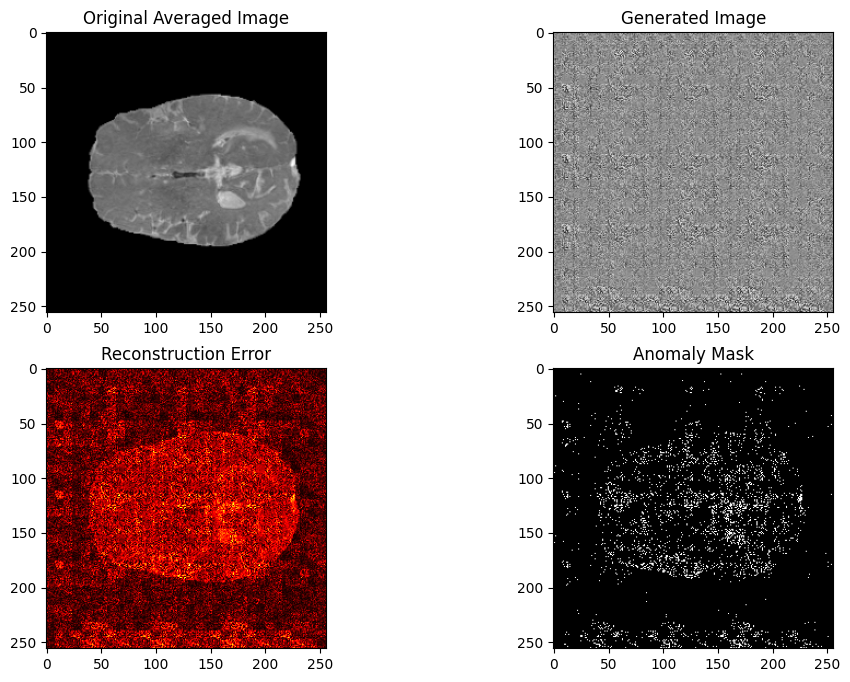

In [22]:
import matplotlib.pyplot as plt

# Display original, generated image, reconstruction error, and anomaly mask
plt.figure(figsize=(12, 8))

# Original Image
plt.subplot(2, 2, 1)
plt.title("Original Averaged Image")
plt.imshow(validation_tensor.squeeze().cpu().numpy(), cmap='gray')

# Generated Image (Fake Image)
noise = torch.randn((1, latent_dim), device=device)
with torch.no_grad():
    generated_img = G(noise).squeeze().cpu().numpy()

plt.subplot(2, 2, 2)
plt.title("Generated Image")
plt.imshow(generated_img, cmap='gray')

# Reconstruction Error
plt.subplot(2, 2, 3)
plt.title("Reconstruction Error")
plt.imshow(reconstruction_error, cmap='hot')

# Anomaly Mask
plt.subplot(2, 2, 4)
plt.title("Anomaly Mask")
plt.imshow(anomaly_mask, cmap='gray')

plt.show()
